## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import seaborn as sns
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"satriaadifirmansyah","key":"006dbae515ec28c175ef6ddd5a715a10"}'}

In [3]:
!pip install kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 96% 366M/380M [00:01<00:00, 304MB/s]
100% 380M/380M [00:01<00:00, 323MB/s]


In [5]:
!unzip augmented-alzheimer-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: OriginalDataset/NonDemented/31 (10).jpg  
  inflating: OriginalDataset/NonDemented/31 (100).jpg  
  inflating: OriginalDataset/NonDemented/31 (11).jpg  
  inflating: OriginalDataset/NonDemented/31 (12).jpg  
  inflating: OriginalDataset/NonDemented/31 (13).jpg  
  inflating: OriginalDataset/NonDemented/31 (14).jpg  
  inflating: OriginalDataset/NonDemented/31 (15).jpg  
  inflating: OriginalDataset/NonDemented/31 (16).jpg  
  inflating: OriginalDataset/NonDemented/31 (17).jpg  
  inflating: OriginalDataset/NonDemented/31 (18).jpg  
  inflating: OriginalDataset/NonDemented/31 (19).jpg  
  inflating: OriginalDataset/NonDemented/31 (2).jpg  
  inflating: OriginalDataset/NonDemented/31 (20).jpg  
  inflating: OriginalDataset/NonDemented/31 (21).jpg  
  inflating: OriginalDataset/NonDemented/31 (22).jpg  
  inflating: OriginalDataset/NonDemented/31 (23).jpg  
  inflating: OriginalDataset/NonDemented/31 (24).jpg  
  inflating: O

### Data Preprocessing

**Dataset Checking**

In [6]:
# Direktori awal untuk train dan test
aug_dir = "/content/AugmentedAlzheimerDataset"
ori_dir = "/content/OriginalDataset"

# Direktori baru untuk dataset gabungan
combined_dir = "alzheimer/dataset/"

In [7]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(aug_dir):
    category_dir = os.path.join(aug_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(ori_dir):
    category_dir = os.path.join(ori_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

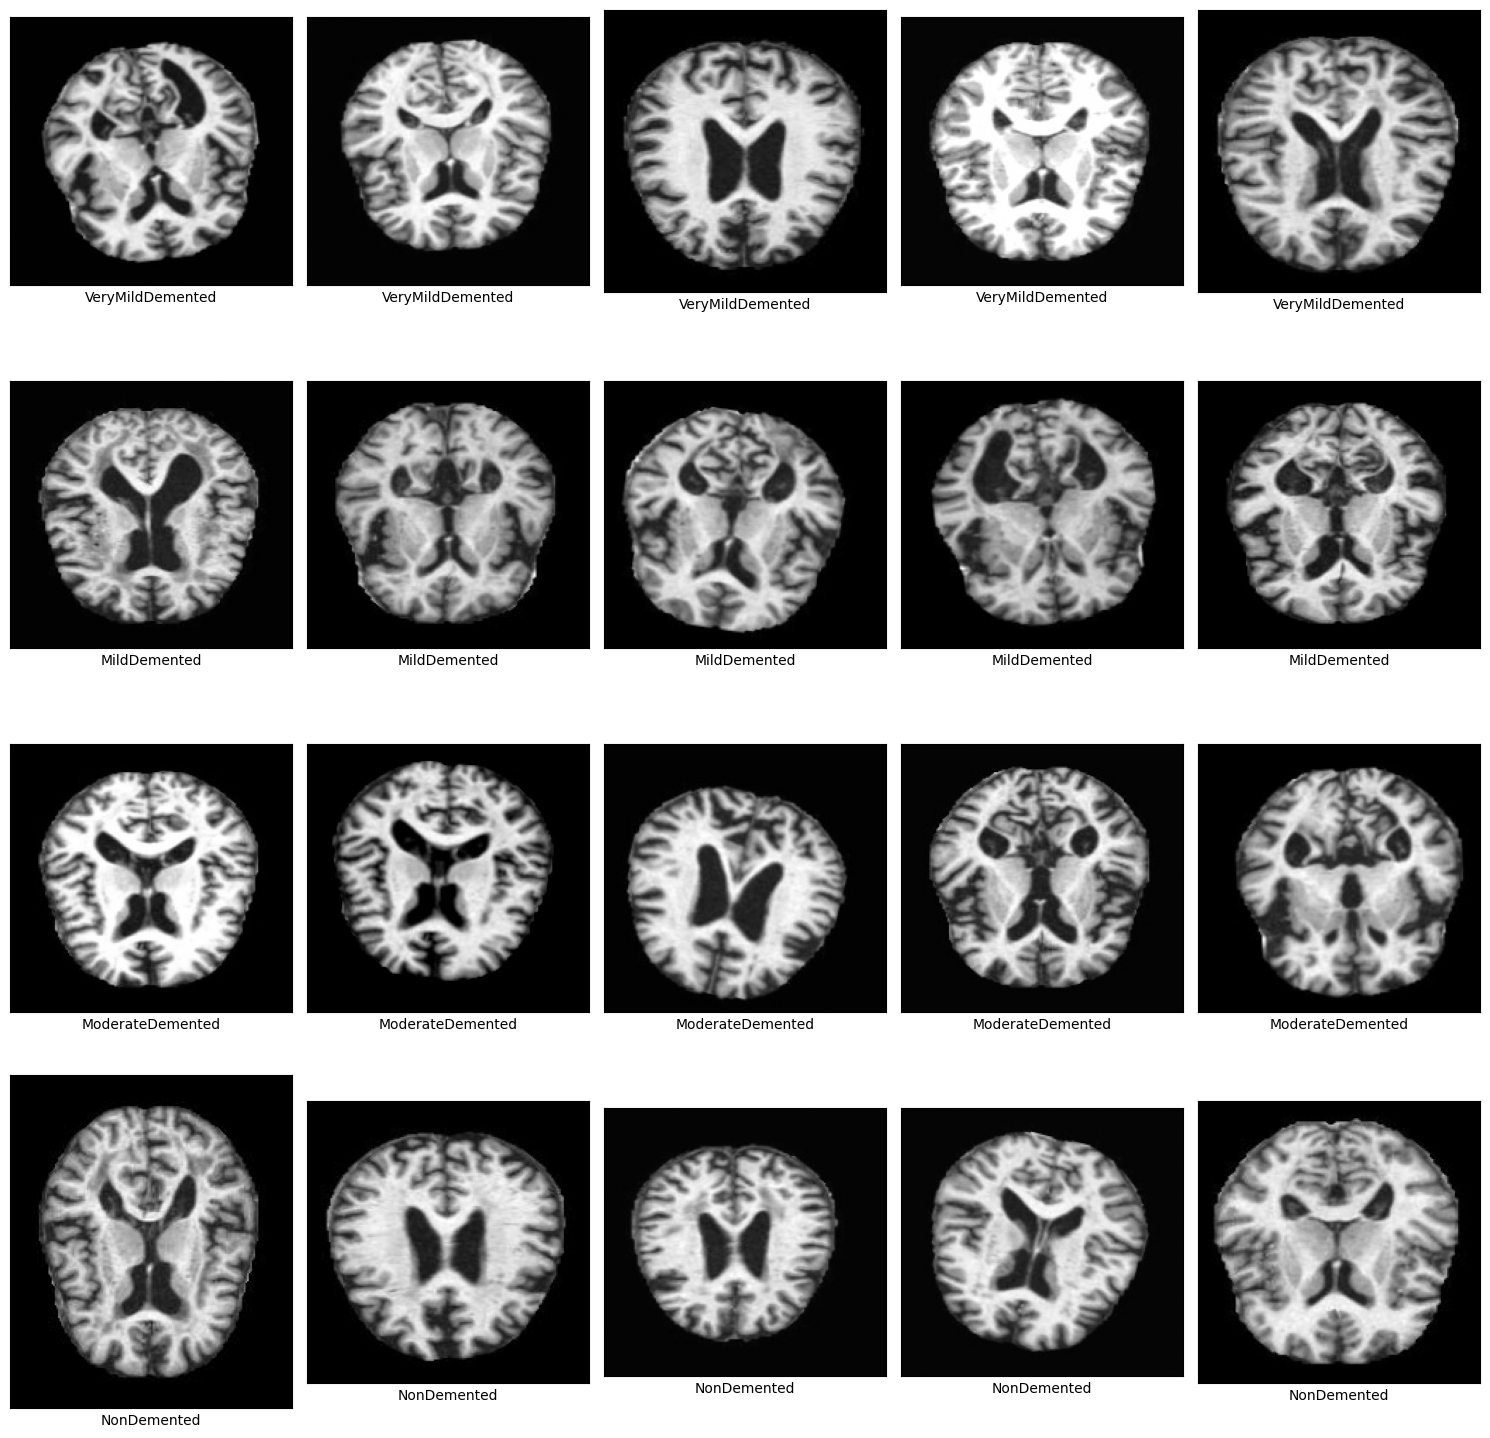

In [8]:
import matplotlib.pyplot as plt

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
alzheimer_img = {}

# Tentukan path sumber train
path = "alzheimer/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    alzheimer_img[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "/content/alzheimer/dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(alzheimer_img.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(alzheimer_img[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Distribution Plot**

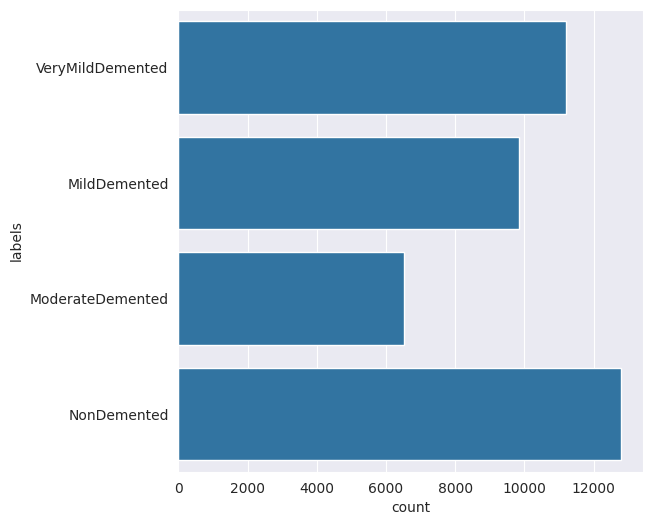

In [9]:
import seaborn as sns

# Definisikan path sumber
alzheimer_path = "/content/alzheimer/dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(alzheimer_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [10]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/alzheimer/dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
MildDemented,9856
ModerateDemented,6528
NonDemented,12800
VeryMildDemented,11200


#### Balancing Dataset

In [11]:

# Paths
original_dataset_path = '/content/alzheimer/dataset'  # the folder with class folders
balanced_dataset_path = '/content/alzheimer/balanced-dataset'  # new balanced output folder

# Target per class
TARGET_COUNT = 13000

# Create directory
os.makedirs(balanced_dataset_path, exist_ok=True)

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Process each class
for class_name in os.listdir(original_dataset_path):
    class_dir = os.path.join(original_dataset_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    print(f"Processing class: {class_name}")

    # Create balanced class directory
    balanced_class_dir = os.path.join(balanced_dataset_path, class_name)
    os.makedirs(balanced_class_dir, exist_ok=True)

    # List images
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    current_count = len(image_files)

    if current_count > TARGET_COUNT:
        # Downsample: randomly select 1500 images
        selected_images = random.sample(image_files, TARGET_COUNT)
    else:
        selected_images = image_files.copy()

    # Copy selected images
    for img_file in selected_images:
        src = os.path.join(class_dir, img_file)
        dst = os.path.join(balanced_class_dir, img_file)
        img = load_img(src)
        save_img(dst, img)

    # If we need more images, augment
    if current_count < TARGET_COUNT:
        images_needed = TARGET_COUNT - current_count
        for i in range(images_needed):
            original_img_file = random.choice(image_files)
            original_img_path = os.path.join(class_dir, original_img_file)

            img = load_img(original_img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            aug_iter = datagen.flow(x, batch_size=1)
            aug_img = next(aug_iter)[0].astype('uint8')

            new_filename = f"aug_{class_name}_{i}.jpg"
            save_img(os.path.join(balanced_class_dir, new_filename), aug_img)

print("✅ All classes are now balanced with 13000 images each!")

Processing class: VeryMildDemented
Processing class: MildDemented
Processing class: ModerateDemented
Processing class: NonDemented
✅ All classes are now balanced with 13000 images each!


In [12]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath_balance= '/content/alzheimer/balanced-dataset'

file_name_new = []
labels_new = []
full_path_new = []
for path, subdirs, files in os.walk(mypath_balance):
    for name in files:
        full_path_new.append(os.path.join(path, name))
        labels_new.append(path.split('/')[-1])
        file_name_new.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df_balance = pd.DataFrame({"path":full_path_new,'file_name':file_name_new,"labels":labels_new})
# Melihat jumlah data gambar pada masing-masing label
df_balance.groupby(['labels']).size()

,0
labels,
MildDemented,13000
ModerateDemented,13000
NonDemented,13000
VeryMildDemented,13000


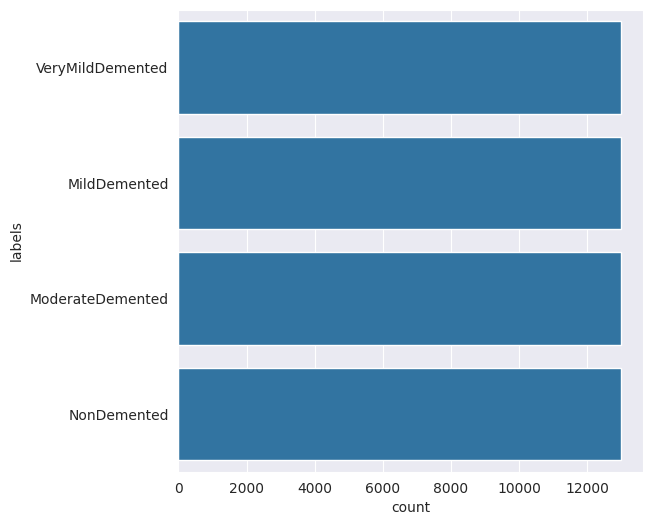

In [13]:
import seaborn as sns

# Definisikan path sumber
sports_balance = "/content/alzheimer/balanced-dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name_new = []
labels_new = []
full_path_new = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(sports_balance):
    for name in files:
        full_path_new.append(os.path.join(path, name))
        labels_new.append(path.split('/')[-1])
        file_name_new.append(name)

distribution_train = pd.DataFrame({"path":full_path_new, 'file_name':file_name_new, "labels":labels_new})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [14]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: Split what's left into training and validation (10% of original = ~12.5% of the temp set)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42
)

In [15]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((28268,), (8077,), (4039,), (28268,), (8077,), (4039,))

In [16]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_va = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})

In [17]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_va], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "sports-classification/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels          
test   MildDemented        1947
       ModerateDemented    1258
       NonDemented         2591
       VeryMildDemented    2281
train  MildDemented        6943
       ModerateDemented    4613
       NonDemented         8895
       VeryMildDemented    7817
val    MildDemented         966
       ModerateDemented     657
       NonDemented         1314
       VeryMildDemented    1102
dtype: int64 


                                                    path        labels    set
12219  /content/alzheimer/dataset/NonDemented/nonDem1...   NonDemented  train
36442  /content/alzheimer/dataset/NonDemented/35472b4...   NonDemented    val
25309  /content/alzheimer/dataset/NonDemented/58711c2...   NonDemented  train
15096  /content/alzheimer/dataset/MildDemented/d6bbc4...  MildDemented  train
13717  /content/alzheimer/dataset/NonDemented/78ef071...   NonDemented  train


In [18]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

In [19]:
# Only basic preprocessing
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    df_tr,
    x_col='path',
    y_col='labels',
    target_size=(256, 256),
    batch_size=300,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    df_va,
    x_col='path',
    y_col='labels',
    target_size=(256, 256),
    batch_size=300,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    df_te,
    x_col='path',
    y_col='labels',
    target_size=(256, 256),
    batch_size=300,
    class_mode='categorical',
    shuffle=False
)

Found 28268 validated image filenames belonging to 4 classes.
Found 4039 validated image filenames belonging to 4 classes.
Found 8077 validated image filenames belonging to 4 classes.


Transfer Learning dengan Resnet50

In [20]:
from tensorflow.keras.applications import ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [22]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    base_model,

    Conv2D(512, 3, (1, 1), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    Conv2D(256, 3, (2, 2), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),

    Dense(128, activation="relu", kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    Dense(4, activation="softmax")
])

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 512)      │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,218,884 (130.53 MB)

 Trainable params: 14,068,612 (53.67 MB)

 Non-trainable params: 20,150,272 (76.87 MB)

In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience = 5, mode = max)

<ipython-input-24-1584475219>:1: UserWarning: EarlyStopping mode <built-in function max> is unknown, fallback to auto mode.
  early_stopping = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience = 5, mode = max)


In [25]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks= early_stopping
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.5268 - loss: 2.7497 - val_accuracy: 0.6304 - val_loss: 1.7298
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8178 - loss: 1.2405 - val_accuracy: 0.7990 - val_loss: 0.9630
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9274 - loss: 0.5903 - val_accuracy: 0.8995 - val_loss: 0.5039
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9654 - loss: 0.2874 - val_accuracy: 0.9119 - val_loss: 0.3617
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9819 - loss: 0.1475 - val_accuracy: 0.9101 - val_loss: 0.3371
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9859 - loss: 0.0902 - val_accuracy: 0.9332 - val_loss: 0.2317
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9899 - loss: 0.0577 - val_accuracy: 0.9302 - val_loss: 0.2485
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9898 - loss: 0.0454 - val_accuracy: 0.8861 - v

## Evaluasi dan Visualisasi

In [26]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9576 - loss: 0.1713
Test Loss: 0.18243004381656647
Test Accuracy: 0.9540671110153198


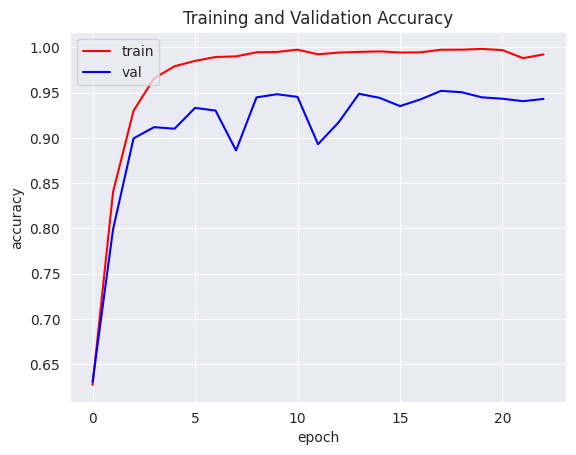

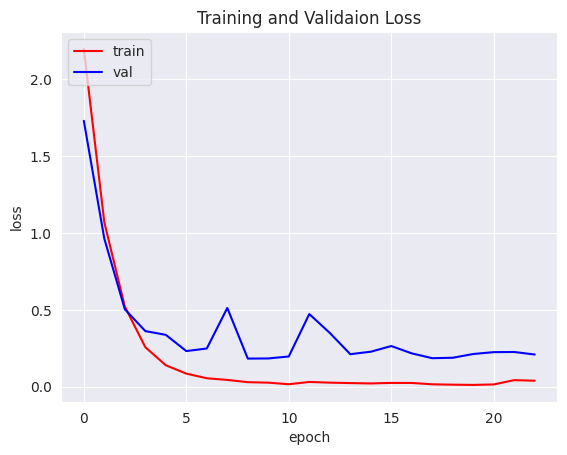

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



                    precision    recall  f1-score   support

     Mild Demented     0.9517    0.9707    0.9611      1947
 Moderate Demented     0.9992    1.0000    0.9996      1258
      Non Demented     0.9274    0.9660    0.9463      2591
Very Mild Demented     0.9634    0.9009    0.9311      2281

          accuracy                         0.9541      8077
         macro avg     0.9604    0.9594    0.9595      8077
      weighted avg     0.9546    0.9541    0.9539      8077



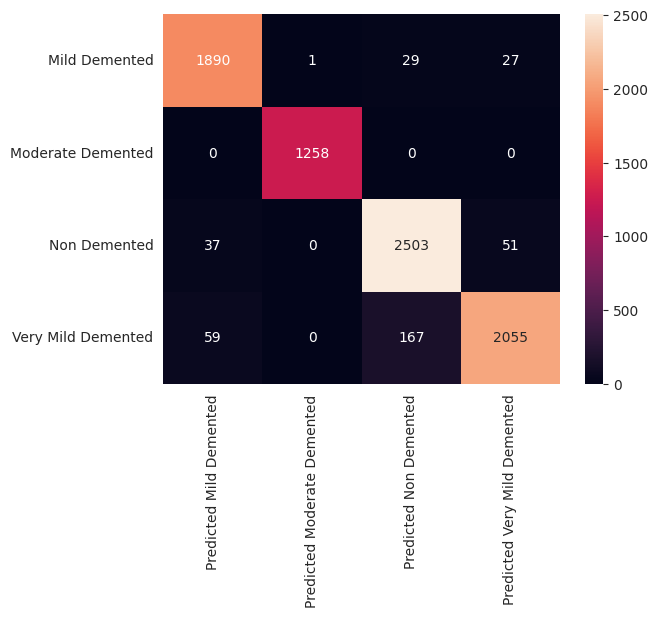

In [28]:
test_generator.reset()

preds_1 = model.predict(test_generator,verbose=0)
predicted_labels = np.argmax(preds_1, axis=1)

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predicted_labels, labels=[0, 1, 2, 3]),index=["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"],
columns=["Predicted Mild Demented", "Predicted Moderate Demented", "Predicted Non Demented", "Predicted Very Mild Demented"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=predicted_labels,target_names =["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"], digits=4))

## Konversi Model

In [29]:
import joblib
joblib.dump(model, 'AlzheimerCapstone.pkl')

['AlzheimerCapstone.pkl']

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Plus TensorFlow ops
]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save it
with open('/content/alzheimer_cc25.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpku5murfk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_190')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133480118656016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133480118650832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133480118651216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133480118652560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133480118652176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133480118656784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133481884219152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133480104820560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133480104808272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133480118649680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1334801186

## Inference (Optional)

Saving 0021740c-fbc2-405c-b0d7-0c7176217933.jpg to 0021740c-fbc2-405c-b0d7-0c7176217933 (1).jpg


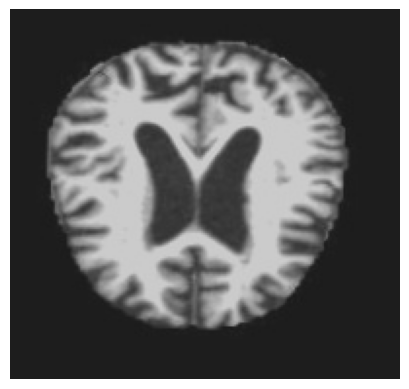

Predicted Label: ModerateDemented (Confidence: 1.00)


In [34]:
import tensorflow as tf
import numpy as np
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

interpreter = tf.lite.Interpreter(model_path="/content/alzheimer_cc25.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def load_labels(label_path="/content/labels.txt"):
    with open(label_path, "r") as file:
        labels = file.read().splitlines()
    return labels

def preprocess_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(target_size)
    image_array = np.array(image, dtype=np.float32) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    if image_array.shape != tuple(input_details[0]['shape']):
      image_array = image_array.reshape(input_details[0]['shape'])
    return image_array

def predict_label(image_path, class_labels):
    image_array = preprocess_image(image_path)

    interpreter.set_tensor(input_details[0]['index'], image_array)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output_data)
    confidence = np.max(output_data)

    return class_labels[predicted_label], confidence

labels = load_labels("/content/labels.txt")

uploaded = files.upload()

for image_name in uploaded.keys():
    # Display the uploaded image
    img = Image.open(image_name)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Get the predicted label and confidence
    label, confidence = predict_label(image_name, labels)
    print(f"Predicted Label: {label} (Confidence: {confidence:.2f})")
